# Wave Combinator Session Data Exploration

This template is designed to help you explore per-session data from the Wave Combinator game.
It presents statistics and visualizations to help you understand characteristics of data for the given file,
and makes it easy to tweak the code to further explore your data.

# Environment Setup and Import

In [107]:
import os
print(os.getcwd())
!pip install --quiet --no-input -r ../../requirements.txt --log ./pip-installations.log

c:\Users\subsc\Documents\_work\FieldDay\OpenGameData\opengamedata-samples\WAVES\explore


In [211]:
# Standard Libraries
import math
import shutil
import urllib.request as urlrequest
from collections import Counter
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
# 3rd-party Libraries
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

Change pandas `max_rows` and `max_columns`

 *Note: There may be other variables to manually change. Look the "Set Variables" section.*

In [109]:
pd.options.display.max_columns = 4000 #@param {type:"integer"}
pd.options.display.max_rows = 60 #@param {type:"integer"}

## Retrieve Data Files

#### Please change `OGD_SERVER` and `zip_name` if you want to get a file from a different location.
#### The cells below will error if `OGD_SERVER` and `zip_name` are invalid.

In [110]:
# Configure Server Info

OGD_SERVER = 'http://opengamedata.fielddaylab.wisc.edu/'
SERVER_DATA_PATH = 'data/WAVES/'

In [111]:
# Get the zip file.

dataset_name = "WAVES_20230201_to_20230228"
zip_name = f"{dataset_name}_5de1a1f_session-features.zip"

# download the file if it doesn't exist.
if not Path(f'./{zip_name}').is_file():
    print(f"Didn't find the file {zip_name} locally, downloading from {OGD_SERVER}...")
    file_url = f"{OGD_SERVER}{SERVER_DATA_PATH}{zip_name}"
    !curl --ssl-no-revoke {file_url} -o {zipname}
    # with urlrequest.urlopen(ogd_server + zipname, verify=False) as remote_file, open(zipname, 'wb') as local_file:
    #     shutil.copyfileobj(remote_file, local_file)
    #     print(f"Successfully downloaded a copy of the file.")
zip_file = ZipFile(Path(f'./{zip_name}'))

### Import Data Files to Jupyter

In [172]:
# Open TSV from the zip file.

tsv_name = f"{dataset_name}_5de1a1f_session-features.tsv"
raw_data = pd.read_csv(zip_file.open(f"{dataset_name}/{tsv_name}"), sep='\t')
data_readme = zip_file.read(f"{dataset_name}/readme.md")

C:\Users\subsc\AppData\Local\Temp\ipykernel_27984\3246919176.py:4: DtypeWarning: Columns (3,11) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv(zip_file.open(f"{dataset_name}/{tsv_name}"), sep='\t')


# Data Overview

### Dataset README

Below, the readme file included with your dataset is displayed.
It includes information on the events and features for Wave Combinator.

In [173]:
display(Markdown(data_readme.decode()))

## Data Logging Info:
See https://github.com/fielddaylab/waves/blob/master/README.md

Wave data is organized into levels, where each level is a distinct puzzle in the game.



### Data "Shape"

In [174]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12127 entries, 0 to 12126
Columns: 861 entries, PlayerID to lvl34_WavelengthGoodMoveCount
dtypes: bool(35), float64(36), int64(422), object(368)
memory usage: 76.8+ MB


In [175]:
print(f"This dataset has {raw_data.shape[0]} Rows, {raw_data.shape[1]} Columns")

This dataset has 12127 Rows, 861 Columns


### Column Names

Each Waves feature data file contains a large number of columns, each representing a single feature of gameplay.
Some features have one column per level, or one column per quiz question.
We call these **per-count** features.
Each **per-count** feature has a prefix indicating whether it was a *per-level* (prefix: `lvl`) or *per-quiz-question* (prefix: `QA`).  
Other features have only one column, based on play across all levels.
We call these **aggregate** or **session** features.

Below, the base feature names are listed.
**Per-count** features have the prefix shown in parentheses, and the number of columns with that base feature name shown to the right.
Note that **aggregate** features each have a "1" on the right, since each has just one column.

In [230]:
id_columns = pd.Index(["SessionID", "PlayerID"])

In [176]:
percount_prefixes = ['lvl', 'QA']
column_groups = {
  pre : []
  for pre in percount_prefixes + ['Aggregate']
}

for col in raw_data.columns:
  pieces = col.split('_')
  prefix = pieces[0]
  found = False
  for pc_pre in percount_prefixes:
    if prefix.startswith(pc_pre):
      column_groups[pc_pre].append(f"({pc_pre}) {pieces[1]}")
      found = True
  if not found:
    column_groups['Aggregate'].append(col)
col_set = Counter(sum(column_groups.values(), []))
print(f"There are {len(raw_data.columns)} columns in {len(col_set)} groups:")
pprint(col_set, compact=False)

There are 861 columns in 39 groups:
Counter({'(lvl) AmplitudeGoodMoveCount': 35,
         '(lvl) BeginCount': 35,
         '(lvl) Completed': 35,
         '(lvl) Completed-Count': 35,
         '(lvl) FirstMoveType': 35,
         '(lvl) OffsetGoodMoveCount': 35,
         '(lvl) PercentAmplitudeGoodMoves': 35,
         '(lvl) PercentAmplitudeMoves': 35,
         '(lvl) PercentOffsetGoodMoves': 35,
         '(lvl) PercentOffsetMoves': 35,
         '(lvl) PercentWavelengthGoodMoves': 35,
         '(lvl) PercentWavelengthMoves': 35,
         '(lvl) SequenceLevel': 35,
         '(lvl) SliderAverageRange': 35,
         '(lvl) SliderAverageStandardDeviations': 35,
         '(lvl) SucceedCount': 35,
         '(lvl) TotalArrowMoves': 35,
         '(lvl) TotalFails': 35,
         '(lvl) TotalLevelTime': 35,
         '(lvl) TotalMoveTypeChanges': 35,
         '(lvl) TotalResets': 35,
         '(lvl) TotalSkips': 35,
         '(lvl) TotalSliderMoves': 35,
         '(lvl) WavelengthGoodMoveCount': 3

### Sample Rows

In [177]:
ROWS_TO_SHOW = 10

raw_data.head(ROWS_TO_SHOW)

PlayerID          SessionID        AverageFails    AverageLevelTime  \
0       NaN  23000213512143300                 1.5  7.7421999999999995   
1       NaN  23010000124797536                 3.7   137.2149714285715   
2       NaN  23010000141655424                None               2.087   
3       NaN  23010000250701290  3.4444444444444446          113.830375   
4       NaN  23010008135855496                 3.0              7.2294   
5       NaN  23010008154774910                 1.0             17.7365   
6       NaN  23010008254474330   2.064516129032258   30.86754285714286   
7       NaN  23010008390986390  1.9047619047619047   39.30672000000001   
8       NaN  23010008402602676                 6.0              8.9855   
9       NaN  23010008435602250                 5.0              15.149   

  AverageMoveTypeChanges  AverageSliderMoves OverallPercentAmplitudeMoves  \
0                    1.0                5.25            9.523809523809524   
1     1.2666666666666666  12.733333333333333           30.602409638554217   
2                   None                None                         None   
3                 1.1875              5.4375            20.43010752688172   
4                    1.0                4.25           17.647058823529413   
5                    1.0                 1.0                          0.0   
6     1.3428571428571427   9.971428571428572           26.685393258426966   
7     1.4166666666666667   5.958333333333333            34.71337579617834   
8                    1.0                 7.0                          0.0   
9                    1.0                 4.5            33.33333333333333   

  OverallPercentOffsetMoves OverallPercentWavelengthMoves  \
0        42.857142857142854             47.61904761904761   
1        31.566265060240962             37.83132530120482   
2                      None                          None   
3         49.46236559139785            30.107526881720432   
4         41.17647058823529             41.17647058823529   
5                     100.0                           0.0   
6        35.674157303370784            37.640449438202246   
7         29.29936305732484             35.98726114649681   
8         57.14285714285714            42.857142857142854   
9         22.22222222222222             44.44444444444444   

  OverallSliderAverageRange OverallSliderAverageStandardDeviations  \
0         9.335645756284796                     2.4508149660462673   
1        38.588474693560315                     12.585013801476284   
2                      None                                   None   
3        29.592033988566385                      9.018553255915066   
4        18.875425721740427                      5.472004881267037   
5        28.508771929824555                      5.864552317095968   
6        42.058106972911865                     14.236017598622457   
7        39.606131996592026                     13.572994875304062   
8          26.3126166415063                     7.8583784879910255   
9        31.497797042964788                     10.308777671883876   

  PersistentSessionID        SessionID.1  lvl0_AmplitudeGoodMoveCount  \
0   23000213512143300  23000213512143300                            0   
1   23010000124797536  23010000124797536                            0   
2   23010000141655424  23010000141655424                            0   
3   23010000250701290  23010000250701290                            0   
4   23010008135855496  23010008135855496                            0   
5   23010008154774910  23010008154774910                            0   
6   23010008254474330  23010008254474330                            0   
7   23010008390986390  23010008390986390                            0   
8   23010008402602676  23010008402602676                            0   
9   23010008435602250  23010008435602250                            0   

   lvl1_AmplitudeGoodMoveCount  lvl2_AmplitudeGoodMoveCount  \
0                            0

### Summary of raw data

In [178]:
raw_data.describe(include='all')

PlayerID     SessionID AverageFails AverageLevelTime  \
count        0.0  1.212700e+04        12127            12127   
unique       NaN           NaN         1204            11451   
top          NaN           NaN         None              0.0   
freq         NaN           NaN         1913              496   
mean         NaN  2.301031e+16          NaN              NaN   
std          NaN  2.099137e+11          NaN              NaN   
min          NaN  2.300021e+16          NaN              NaN   
25%          NaN  2.301021e+16          NaN              NaN   
50%          NaN  2.301031e+16          NaN              NaN   
75%          NaN  2.301041e+16          NaN              NaN   
max          NaN  2.302032e+16          NaN              NaN   

       AverageMoveTypeChanges AverageSliderMoves OverallPercentAmplitudeMoves  \
count                   12127              12127                        12127   
unique                    658               1967                         3410   
top                       1.0               None                         None   
freq                     6163                655                          615   
mean                      NaN                NaN                          NaN   
std                       NaN                NaN                          NaN   
min                       NaN                NaN                          NaN   
25%                       NaN                NaN                          NaN   
50%                       NaN                NaN                          NaN   
75%                       NaN                NaN                          NaN   
max                       NaN                NaN                          NaN   

       OverallPercentOffsetMoves OverallPercentWavelengthMoves  \
count                      12127                         12127   
unique                      3475                          3518   
top                         None                          None   
freq                         615                           615   
mean                         NaN                           NaN   
std                          NaN                           NaN   
min                          NaN                           NaN   
25%                          NaN                           NaN   
50%                          NaN                           NaN   
75%                          NaN                           NaN   
max                          NaN                           NaN   

       OverallSliderAverageRange OverallSliderAverageStandardDeviations  \
count                      12127                                  12127   
unique                     11399                                  11472   
top                         None                                   None   
freq                         655                                    655   
mean                         NaN                                    NaN   
std                          NaN                                    NaN   
min                          NaN                                    NaN   
25%                          NaN                                    NaN   
50%                          NaN                                    NaN   
75%                          NaN                                    NaN   
max                          NaN                                    NaN   

       PersistentSessionID   SessionID.1  lvl0_AmplitudeGoodMoveCount  \
count                12127  1.212700e+04                 12127.000000   
unique               11470           NaN                          NaN   
top                   None           NaN                          NaN   
freq                    28           NaN                          NaN   
mean                   NaN  2.301031e+16                     0.042137   
std                    NaN  2.099137e+11                     1.056832   
min                    NaN  2.300021e+16                     

# Cleaning and Transforms

#### Convert data types in any cases where Pandas picked wrong type

In [179]:
typed_data = raw_data.replace({'None':None})

In [180]:
# typed_data = typed_data.convert_dtypes()

# For string types, try to parse as a timedelta, in case that's what was meant to be there (Pandas doesn't seem to do this automatically)
for col, dtype in zip(typed_data, typed_data.dtypes):
  if dtype == "string":
    try:
      typed_data[col] = pd.to_timedelta(typed_data[col])
    except:
      try:
        typed_data[col] = pd.to_numeric(typed_data[col])
      except:
        pass
  elif dtype == "object":
      try:
        typed_data[col] = pd.to_numeric(typed_data[col])
      except:
        pass

print(f"This dataframe contains data of the following types:\n{typed_data.dtypes.unique()}\n")
print(f"Per feature, the data types are:\n{typed_data.dtypes}")

This dataframe contains data of the following types:
[dtype('float64') dtype('int64') dtype('bool') dtype('O')]

Per feature, the data types are:
PlayerID                         float64
SessionID                          int64
AverageFails                     float64
AverageLevelTime                 float64
AverageMoveTypeChanges           float64
                                  ...   
lvl30_WavelengthGoodMoveCount      int64
lvl31_WavelengthGoodMoveCount      int64
lvl32_WavelengthGoodMoveCount      int64
lvl33_WavelengthGoodMoveCount      int64
lvl34_WavelengthGoodMoveCount      int64
Length: 861, dtype: object


## Data Cleaning

#### Check for invalid Session IDs and null data.

In [181]:
bad_session_id = typed_data[typed_data.SessionID.isna()]
print(f"There are {bad_session_id.shape[0]} rows containing invalid Session IDs.")
bad_session_id.head(10)

There are 0 rows containing invalid Session IDs.


,PlayerID,SessionID,AverageFails,AverageLevelTime,AverageMoveTypeChanges,AverageSliderMoves,OverallPercentAmplitudeMoves,OverallPercentOffsetMoves,OverallPercentWavelengthMoves,OverallSliderAverageRange,OverallSliderAverageStandardDeviations,PersistentSessionID,SessionID.1,lvl0_AmplitudeGoodMoveCount,lvl1_AmplitudeGoodMoveCount,lvl2_AmplitudeGoodMoveCount,lvl3_AmplitudeGoodMoveCount,lvl4_AmplitudeGoodMoveCount,lvl5_AmplitudeGoodMoveCount,lvl6_AmplitudeGoodMoveCount,lvl7_AmplitudeGoodMoveCount,lvl8_AmplitudeGoodMoveCount,lvl9_AmplitudeGoodMoveCount,lvl10_AmplitudeGoodMoveCount,lvl11_AmplitudeGoodMoveCount,lvl12_AmplitudeGoodMoveCount,lvl13_AmplitudeGoodMoveCount,lvl14_AmplitudeGoodMoveCount,lvl15_AmplitudeGoodMoveCount,lvl16_AmplitudeGoodMoveCount,lvl17_AmplitudeGoodMoveCount,lvl18_AmplitudeGoodMoveCount,lvl19_AmplitudeGoodMoveCount,lvl20_AmplitudeGoodMoveCount,lvl21_AmplitudeGoodMoveCount,lvl22_AmplitudeGoodMoveCount,lvl23_AmplitudeGoodMoveCount,lvl24_AmplitudeGoodMoveCount,lvl25_AmplitudeGoodMoveCount,lvl26_AmplitudeGoodMoveCount,lvl27_AmplitudeGoodMoveCount,lvl28_AmplitudeGoodMoveCount,lvl29_AmplitudeGoodMoveCount,lvl30_AmplitudeGoodMoveCount,lvl31_AmplitudeGoodMoveCount,lvl32_AmplitudeGoodMoveCount,lvl33_AmplitudeGoodMoveCount,lvl34_AmplitudeGoodMoveCount,lvl0_BeginCount,lvl1_BeginCount,lvl2_BeginCount,lvl3_BeginCount,lvl4_BeginCount,lvl5_BeginCount,lvl6_BeginCount,lvl7_BeginCount,lvl8_BeginCount,lvl9_BeginCount,lvl10_BeginCount,lvl11_BeginCount,lvl12_BeginCount,lvl13_BeginCount,lvl14_BeginCount,lvl15_BeginCount,lvl16_BeginCount,lvl17_BeginCount,lvl18_BeginCount,lvl19_BeginCount,lvl20_BeginCount,lvl21_BeginCount,lvl22_BeginCount,lvl23_BeginCount,lvl24_BeginCount,lvl25_BeginCount,lvl26_BeginCount,lvl27_BeginCount,lvl28_BeginCount,lvl29_BeginCount,lvl30_BeginCount,lvl31_BeginCount,lvl32_BeginCount,lvl33_BeginCount,lvl34_BeginCount,lvl0_Completed,lvl0_Completed-Count,lvl1_Completed,lvl1_Completed-Count,lvl2_Completed,lvl2_Completed-Count,lvl3_Completed,lvl3_Completed-Count,lvl4_Completed,lvl4_Completed-Count,lvl5_Completed,lvl5_Completed-Count,lvl6_Completed,lvl6_Completed-Count,lvl7_Completed,lvl7_Completed-Count,lvl8_Completed,lvl8_Completed-Count,lvl9_Completed,lvl9_Completed-Count,lvl10_Completed,lvl10_Completed-Count,lvl11_Completed,lvl11_Completed-Count,lvl12_Completed,lvl12_Completed-Count,lvl13_Completed,lvl13_Completed-Count,lvl14_Completed,lvl14_Completed-Count,lvl15_Completed,lvl15_Completed-Count,lvl16_Completed,lvl16_Completed-Count,lvl17_Completed,lvl17_Completed-Count,lvl18_Completed,lvl18_Completed-Count,lvl19_Completed,lvl19_Completed-Count,lvl20_Completed,lvl20_Completed-Count,lvl21_Completed,lvl21_Completed-Count,lvl22_Completed,lvl22_Completed-Count,lvl23_Completed,lvl23_Completed-Count,lvl24_Completed,lvl24_Completed-Count,lvl25_Completed,lvl25_Completed-Count,lvl26_Completed,lvl26_Completed-Count,lvl27_Completed,lvl27_Completed-Count,lvl28_Completed,lvl28_Completed-Count,lvl29_Completed,lvl29_Completed-Count,lvl30_Completed,lvl30_Completed-Count,lvl31_Completed,lvl31_Completed-Count,lvl32_Completed,lvl32_Completed-Count,lvl33_Completed,lvl33_Completed-Count,lvl34_Completed,lvl34_Completed-Count,lvl0_FirstMoveType,lvl1_FirstMoveType,lvl2_FirstMoveType,lvl3_FirstMoveType,lvl4_FirstMoveType,lvl5_FirstMoveType,lvl6_FirstMoveType,lvl7_FirstMoveType,lvl8_FirstMoveType,lvl9_FirstMoveType,lvl10_FirstMoveType,lvl11_FirstMoveType,lvl12_FirstMoveType,lvl13_FirstMoveType,lvl14_FirstMoveType,lvl15_FirstMoveType,lvl16_FirstMoveType,lvl17_FirstMoveType,lvl18_FirstMoveType,lvl19_FirstMoveType,lvl20_FirstMoveType,lvl21_FirstMoveType,lvl22_FirstMoveType,lvl23_FirstMoveType,lvl24_FirstMoveType,lvl25_FirstMoveType,lvl26_FirstMoveType,lvl27_FirstMoveType,lvl28_FirstMoveType,lvl29_FirstMoveType,lvl30_FirstMoveType,lvl31_FirstMoveType,lvl32_FirstMoveType,lvl33_FirstMoveType,lvl34_FirstMoveType,lvl0_OffsetGoodMoveCount,lvl1_OffsetGoodMoveCount,lvl2_OffsetGoodMoveCount,lvl3_OffsetGoodMoveCount,lvl4_OffsetGoodMoveCount,lvl5_Offset

In [195]:
null_data = typed_data.loc[:, typed_data.columns != 'PlayerID'][typed_data.isnull().any(axis = 1)]
print(f"There are {null_data.shape[0]} rows containing null data.\nFirst five rows containing null data:\n")
null_data.head(5)

There are 12127 rows containing null data.
First five rows containing null data:



,SessionID,AverageFails,AverageLevelTime,AverageMoveTypeChanges,AverageSliderMoves,OverallPercentAmplitudeMoves,OverallPercentOffsetMoves,OverallPercentWavelengthMoves,OverallSliderAverageRange,OverallSliderAverageStandardDeviations,PersistentSessionID,SessionID.1,lvl0_AmplitudeGoodMoveCount,lvl1_AmplitudeGoodMoveCount,lvl2_AmplitudeGoodMoveCount,lvl3_AmplitudeGoodMoveCount,lvl4_AmplitudeGoodMoveCount,lvl5_AmplitudeGoodMoveCount,lvl6_AmplitudeGoodMoveCount,lvl7_AmplitudeGoodMoveCount,lvl8_AmplitudeGoodMoveCount,lvl9_AmplitudeGoodMoveCount,lvl10_AmplitudeGoodMoveCount,lvl11_AmplitudeGoodMoveCount,lvl12_AmplitudeGoodMoveCount,lvl13_AmplitudeGoodMoveCount,lvl14_AmplitudeGoodMoveCount,lvl15_AmplitudeGoodMoveCount,lvl16_AmplitudeGoodMoveCount,lvl17_AmplitudeGoodMoveCount,lvl18_AmplitudeGoodMoveCount,lvl19_AmplitudeGoodMoveCount,lvl20_AmplitudeGoodMoveCount,lvl21_AmplitudeGoodMoveCount,lvl22_AmplitudeGoodMoveCount,lvl23_AmplitudeGoodMoveCount,lvl24_AmplitudeGoodMoveCount,lvl25_AmplitudeGoodMoveCount,lvl26_AmplitudeGoodMoveCount,lvl27_AmplitudeGoodMoveCount,lvl28_AmplitudeGoodMoveCount,lvl29_AmplitudeGoodMoveCount,lvl30_AmplitudeGoodMoveCount,lvl31_AmplitudeGoodMoveCount,lvl32_AmplitudeGoodMoveCount,lvl33_AmplitudeGoodMoveCount,lvl34_AmplitudeGoodMoveCount,lvl0_BeginCount,lvl1_BeginCount,lvl2_BeginCount,lvl3_BeginCount,lvl4_BeginCount,lvl5_BeginCount,lvl6_BeginCount,lvl7_BeginCount,lvl8_BeginCount,lvl9_BeginCount,lvl10_BeginCount,lvl11_BeginCount,lvl12_BeginCount,lvl13_BeginCount,lvl14_BeginCount,lvl15_BeginCount,lvl16_BeginCount,lvl17_BeginCount,lvl18_BeginCount,lvl19_BeginCount,lvl20_BeginCount,lvl21_BeginCount,lvl22_BeginCount,lvl23_BeginCount,lvl24_BeginCount,lvl25_BeginCount,lvl26_BeginCount,lvl27_BeginCount,lvl28_BeginCount,lvl29_BeginCount,lvl30_BeginCount,lvl31_BeginCount,lvl32_BeginCount,lvl33_BeginCount,lvl34_BeginCount,lvl0_Completed,lvl0_Completed-Count,lvl1_Completed,lvl1_Completed-Count,lvl2_Completed,lvl2_Completed-Count,lvl3_Completed,lvl3_Completed-Count,lvl4_Completed,lvl4_Completed-Count,lvl5_Completed,lvl5_Completed-Count,lvl6_Completed,lvl6_Completed-Count,lvl7_Completed,lvl7_Completed-Count,lvl8_Completed,lvl8_Completed-Count,lvl9_Completed,lvl9_Completed-Count,lvl10_Completed,lvl10_Completed-Count,lvl11_Completed,lvl11_Completed-Count,lvl12_Completed,lvl12_Completed-Count,lvl13_Completed,lvl13_Completed-Count,lvl14_Completed,lvl14_Completed-Count,lvl15_Completed,lvl15_Completed-Count,lvl16_Completed,lvl16_Completed-Count,lvl17_Completed,lvl17_Completed-Count,lvl18_Completed,lvl18_Completed-Count,lvl19_Completed,lvl19_Completed-Count,lvl20_Completed,lvl20_Completed-Count,lvl21_Completed,lvl21_Completed-Count,lvl22_Completed,lvl22_Completed-Count,lvl23_Completed,lvl23_Completed-Count,lvl24_Completed,lvl24_Completed-Count,lvl25_Completed,lvl25_Completed-Count,lvl26_Completed,lvl26_Completed-Count,lvl27_Completed,lvl27_Completed-Count,lvl28_Completed,lvl28_Completed-Count,lvl29_Completed,lvl29_Completed-Count,lvl30_Completed,lvl30_Completed-Count,lvl31_Completed,lvl31_Completed-Count,lvl32_Completed,lvl32_Completed-Count,lvl33_Completed,lvl33_Completed-Count,lvl34_Completed,lvl34_Completed-Count,lvl0_FirstMoveType,lvl1_FirstMoveType,lvl2_FirstMoveType,lvl3_FirstMoveType,lvl4_FirstMoveType,lvl5_FirstMoveType,lvl6_FirstMoveType,lvl7_FirstMoveType,lvl8_FirstMoveType,lvl9_FirstMoveType,lvl10_FirstMoveType,lvl11_FirstMoveType,lvl12_FirstMoveType,lvl13_FirstMoveType,lvl14_FirstMoveType,lvl15_FirstMoveType,lvl16_FirstMoveType,lvl17_FirstMoveType,lvl18_FirstMoveType,lvl19_FirstMoveType,lvl20_FirstMoveType,lvl21_FirstMoveType,lvl22_FirstMoveType,lvl23_FirstMoveType,lvl24_FirstMoveType,lvl25_FirstMoveType,lvl26_FirstMoveType,lvl27_FirstMoveType,lvl28_FirstMoveType,lvl29_FirstMoveType,lvl30_FirstMoveType,lvl31_FirstMoveType,lvl32_FirstMoveType,lvl33_FirstMoveType,lvl34_FirstMoveType,lvl0_OffsetGoodMoveCount,lvl1_OffsetGoodMoveCount,lvl2_OffsetGoodMoveCount,lvl3_OffsetGoodMoveCount,lvl4_OffsetGoodMoveCount,lvl5_OffsetGoodMoveC

#### Remove sessions based on NaNs in specific columns

In [183]:
# All sessions have some NaN data; choose any columns for which you'd like to drop sessions that had NaN in those specific columns:
# Note that the "count" in the summary indicates how many rows have non-null/non-NA values in them.
drop_nas = ["AverageLevelTime"]

df_session = typed_data.dropna(subset=drop_nas)
df_session.reset_index(inplace=True)
print(f"After removing rows with NA values, there are {df_session.shape[0]} rows remaining")

After removing rows with NA values, there are 12099 rows remaining


## Finding outliers

Execute the following chunk only when the features are timedelta

In [189]:
# for col in target_columns:
#   df_Interested[col] = df_Interested[col].dt.total_seconds()


In [199]:
# bigoutliers = np.where(df_Interested[target_columns].ge(4000))
# bigoutliers

(array([], dtype=int64), array([], dtype=int64))

In [192]:
# for i, j in zip(bigoutliers[0], bigoutliers[1]):
#   df_Interested[target_columns].iat[i, j] = 0

## Data Transforms

# Feature Summaries

This section shows some basic statistical summaries of the feature columns listed previously.
These summaries are across all sessions in the data file.

#### Summary of Aggregate (whole-session) features

In [184]:
df_session[column_groups['Aggregate']].describe(include = 'all')

,PlayerID,SessionID,AverageFails,AverageLevelTime,AverageMoveTypeChanges,AverageSliderMoves,OverallPercentAmplitudeMoves,OverallPercentOffsetMoves,OverallPercentWavelengthMoves,OverallSliderAverageRange,OverallSliderAverageStandardDeviations,PersistentSessionID,SessionID.1
count,0.0,1.209900e+04,10214.000000,12099.000000,11512.000000,11472.000000,11512.000000,11512.000000,11512.000000,1.147200e+04,1.147200e+04,1.209900e+04,1.209900e+04
mean,NaN,2.301031e+16,4.395034,105.725985,1.600563,9.062432,25.544463,36.852451,37.603087,2.896399e+01,9.265761e+00,2.300597e+16,2.301031e+16
std,NaN,2.100759e+11,5.955671,794.665767,1.339763,6.668649,11.765121,14.642136,12.960949,1.232078e+01,4.566817e+00,6.191243e+13,2.100759e+11
min,NaN,2.300021e+16,1.000000,-66.135500,1.000000,1.000000,0.000000,0.000000,0.000000,1.421085e-14,7.105427e-15,2.210002e+16,2.300021e+16
25%,NaN,2.301021e+16,2.125000,12.879889,1.000000,5.000000,19.512195,29.411765,31.818182,2.109216e+01,6.471085e+00,2.301021e+16,2.301021e+16
50%,NaN,2.301031e+16,3.000000,30.919700,1.000000,7.579545,25.757576,35.196183,37.037037,2.660803e+01,8.333328e+00,2.301031e+16,2.301031e+16
75%,NaN,2.301041e+16,4.555556,58.941682,1.643433,11.444444,31.602242,41.428571,42.857143,3.347794e+01,1.074907e+01,2.301041e+16,2.301041e+16
max,NaN,2.302032e+16,284.000000,34555.889000,36.500000,162.000000,100.000000,100.000000,100.000000,1.000000e+02,4.577055e+01,2.302032e+16,2.302032e+16


#### Summary of a Per-Count feature

In [185]:
# Choose which per-count feature you'd like to see summarized
per_count = "AmplitudeGoodMoveCount"

cols = [col for col in raw_data.columns if col.endswith(per_count)]
raw_data[cols].describe(include='all')

,lvl0_AmplitudeGoodMoveCount,lvl1_AmplitudeGoodMoveCount,lvl2_AmplitudeGoodMoveCount,lvl3_AmplitudeGoodMoveCount,lvl4_AmplitudeGoodMoveCount,lvl5_AmplitudeGoodMoveCount,lvl6_AmplitudeGoodMoveCount,lvl7_AmplitudeGoodMoveCount,lvl8_AmplitudeGoodMoveCount,lvl9_AmplitudeGoodMoveCount,lvl10_AmplitudeGoodMoveCount,lvl11_AmplitudeGoodMoveCount,lvl12_AmplitudeGoodMoveCount,lvl13_AmplitudeGoodMoveCount,lvl14_AmplitudeGoodMoveCount,lvl15_AmplitudeGoodMoveCount,lvl16_AmplitudeGoodMoveCount,lvl17_AmplitudeGoodMoveCount,lvl18_AmplitudeGoodMoveCount,lvl19_AmplitudeGoodMoveCount,lvl20_AmplitudeGoodMoveCount,lvl21_AmplitudeGoodMoveCount,lvl22_AmplitudeGoodMoveCount,lvl23_AmplitudeGoodMoveCount,lvl24_AmplitudeGoodMoveCount,lvl25_AmplitudeGoodMoveCount,lvl26_AmplitudeGoodMoveCount,lvl27_AmplitudeGoodMoveCount,lvl28_AmplitudeGoodMoveCount,lvl29_AmplitudeGoodMoveCount,lvl30_AmplitudeGoodMoveCount,lvl31_AmplitudeGoodMoveCount,lvl32_AmplitudeGoodMoveCount,lvl33_AmplitudeGoodMoveCount,lvl34_AmplitudeGoodMoveCount
count,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000,12127.000000
mean,0.042137,0.506143,0.799043,2.027954,2.953327,2.342459,1.164014,0.080564,0.642616,2.823699,0.029109,0.186279,0.040241,0.158324,0.156345,0.642368,0.174899,0.165993,0.000825,0.022264,0.034963,0.104807,0.212996,0.171436,0.142492,0.188258,0.091201,0.073225,0.094170,0.040406,0.084934,0.024326,0.047662,0.192216,0.047662
std,1.056832,2.908400,4.691148,8.197874,9.096544,9.762700,5.094738,1.739564,2.572824,11.576489,0.922295,1.760344,0.766826,1.704986,1.905606,3.769172,2.378432,1.713787,0.042586,0.702602,0.484901,1.239496,2.711708,1.462449,1.853664,2.631424,0.853587,1.048352,0.967664,0.678734,1.518714,0.742649,0.959017,1.777332,0.756981
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,89.000000,137.000000,183.000000,236.000000,273.000000,244.000000,136.000000,81.000000,109.000000,408.000000,51.000000,103.000000,61.000000,90.000000,123.000000,135.000000,108.000000,72.000000,3.000000,73.000000,33.000000,61.000000,181.000000,63.000000,131.000000,127.000000,44.000000,55.000000,39.000000,26.000000,139.000000,64.000000,47.000000,63.000000,42.000000


# Visualizations

### Simple feature value distribution visualization

In [225]:
feature_to_visualize = "AverageLevelTime"
minimum_value = -math.inf
maximum_value = math.inf

count    12099.000000
mean       105.725985
std        794.665767
min        -66.135500
25%         12.879889
50%         30.919700
75%         58.941682
max      34555.889000
Name: AverageLevelTime, dtype: float64


(array([1.2035e+04, 2.5000e+01, 1.9000e+01, 8.0000e+00, 6.0000e+00,
        4.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  -66.1355 ,  3396.06695,  6858.2694 , 10320.47185, 13782.6743 ,
        17244.87675, 20707.0792 , 24169.28165, 27631.4841 , 31093.68655,
        34555.889  ]),
 <BarContainer object of 10 artists>)

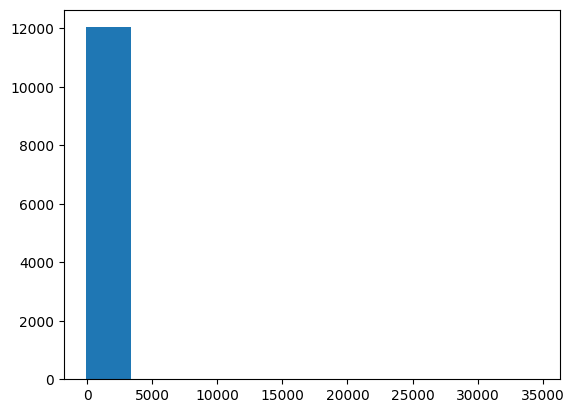

In [228]:
range_filter = (df_session[feature_to_visualize] > minimum_value) & (df_session[feature_to_visualize] < maximum_value)
plot_data = df_session[feature_to_visualize][range_filter]
print(plot_data.describe())
plt.hist(plot_data)

### Simple feature comparison scatterplot

In [236]:
x_axis_feature = "AverageFails"
minimum_x_value = -math.inf
maximum_x_value = math.inf
y_axis_feature = "AverageLevelTime"
minimum_y_value = -math.inf
maximum_y_value = math.inf

       AverageFails  AverageLevelTime
count  10214.000000      10214.000000
mean       4.395034        122.963401
std        5.955671        863.582203
min        1.000000        -66.135500
25%        2.125000         19.306933
50%        3.000000         36.724239
75%        4.555556         65.492238
max      284.000000      34555.889000


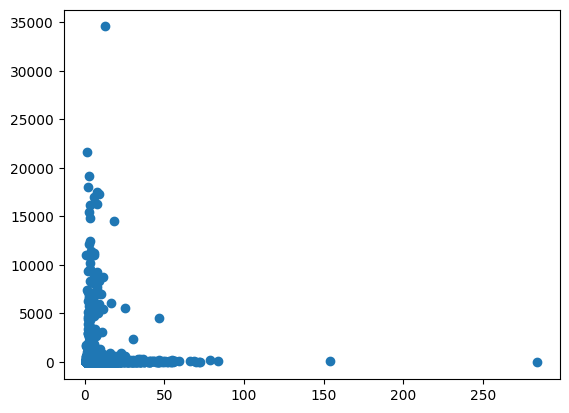

In [237]:
range_filter = (df_session[x_axis_feature] > minimum_x_value) & (df_session[x_axis_feature] < maximum_x_value) \
             & (df_session[y_axis_feature] > minimum_y_value) & (df_session[y_axis_feature] < maximum_y_value)
scatter_data = df_session[[x_axis_feature, y_axis_feature]][range_filter]
print(scatter_data.describe())
plt.scatter(scatter_data[x_axis_feature], scatter_data[y_axis_feature])

## How Many Players?

In [261]:
# Not just "how many played at all", but "how many played and completed at least one level", or "played at least one minute."
level_completion_columns = df_session[df_session.columns[df_session.columns.str.endswith("Completed")]]

level_completion_columns["TotalLevelsCompleted"] = level_completion_columns.sum(axis=1)

C:\Users\subsc\AppData\Local\Temp\ipykernel_27984\2697441872.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level_completion_columns["TotalLevelsCompleted"] = level_completion_columns.sum(axis=1)


In [260]:
print(f"There were {df_session.shape[0]} sessions in the dataset (after cleaning).\nOf those, {level_completion_columns[level_completion_columns['TotalLevelsCompleted'] >= 1].shape[0]} sessions completed at least one level.")

There were 12099 sessions in the dataset (after cleaning).
Of those, 11507 sessions completed at least one level.


## How Far Did They Get?

Text(0.5, 1.0, 'Histogram for # of Different Levels Completed')

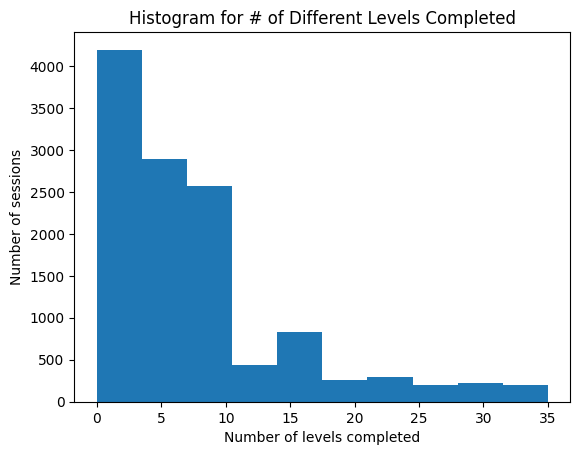

In [256]:
plt.hist(level_completion_columns["TotalLevelsCompleted"])
plt.xlabel("Number of levels completed")
plt.ylabel("Number of sessions")
plt.title("Histogram for # of Different Levels Completed")

## How Long Did They Play?

### heatmap

In [198]:
target_columns = df_session.columns[df_session.columns.str.contains(FEATURE_TO_VISUALIZE)]
df_Interested = df_session[id_columns.append(target_columns)].copy()
df_Interested.head()

,SessionID,PlayerID,AverageSliderMoves
0,23000213512143300,NaN,5.250000
1,23010000124797536,NaN,12.733333
2,23010000141655424,NaN,NaN
3,23010000250701290,NaN,5.437500
4,23010008135855496,NaN,4.250000


ValueError: zero-size array to reduction operation fmin which has no identity

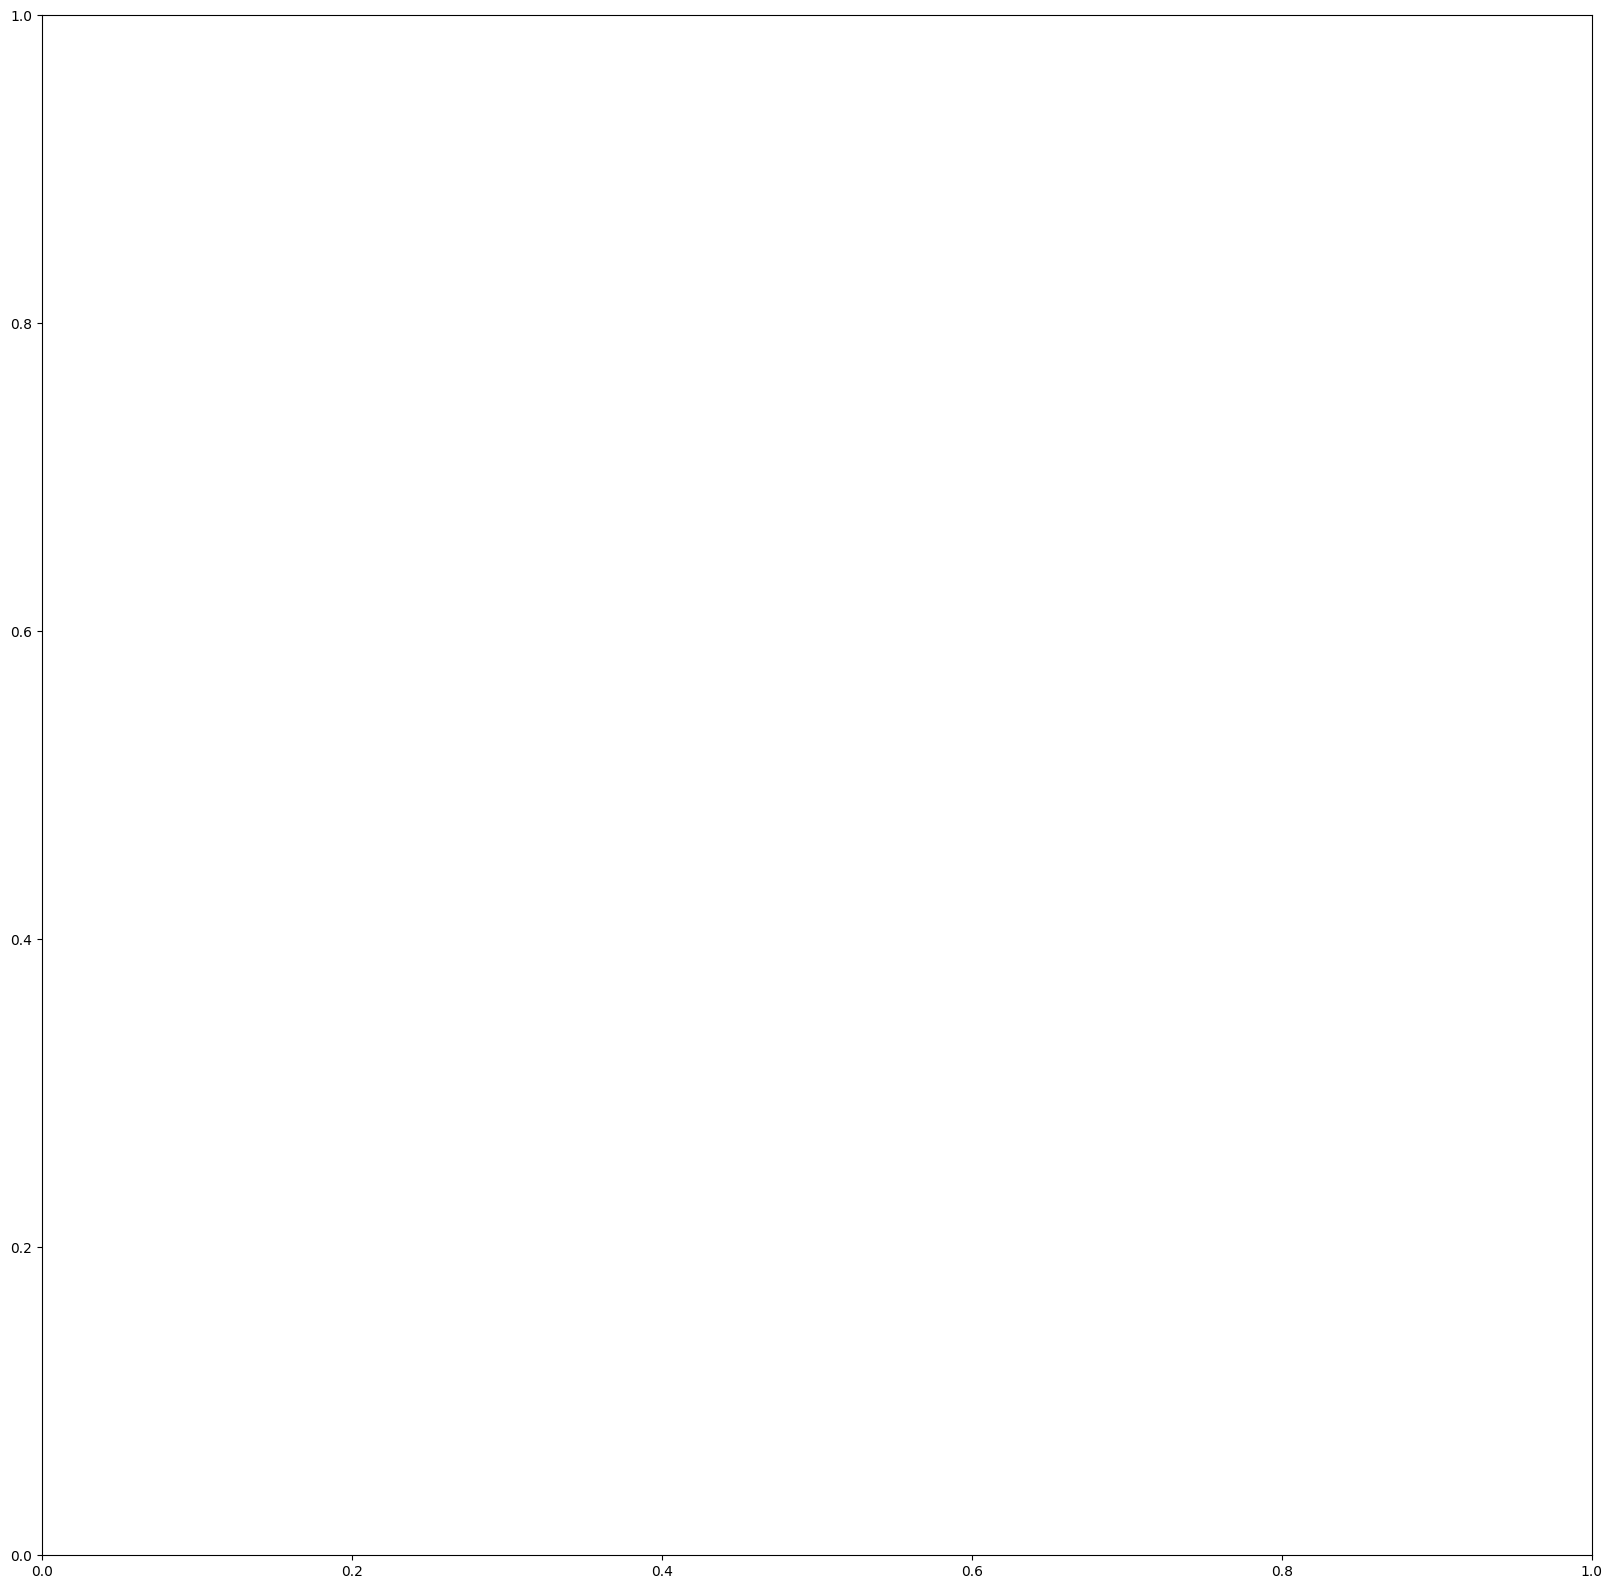

In [193]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
if Answer:
  sns.heatmap(df_Interested.loc[0:60, target_columns[1:]], yticklabels=df_Interested.SessionID[0:60], ax=ax)
else:
  sns.heatmap(df_Interested.loc[0:60, target_columns], yticklabels=df_Interested.SessionID[0:60], ax=ax)


## Some Aggregate feature visualization

#### Cleaning for visualizations

In [ ]:
target_columns = df_session.columns[~df_session.columns.str.contains('job')]
df_Aggregate = df_session[target_columns].copy()

In [ ]:
df_Aggregate.head()

,index,SessionID,PlayerID,ActiveTime,JobsCompleted,SessionDiveSitesCount,SessionDuration,SessionGuideCount,SessionHelpCount,SessionID.1,SessionJobsCompleted,SwitchJobsCount,TopJobCompletionDestinations,TopJobSwitchDestinations,TotalArgumentationTime,TotalDiveTime,TotalExperimentationTime,UserAvgSessionDuration,UserSessionCount,UserTotalSessionDuration
0,1,1664631374,EternalLava,0 days 00:12:31,"['displaced-reef', 'turtle-danger']",2,0 days 00:16:45,0,0,1664631374,2,6,"{""displaced-reef"": {""turtle-danger"": [""Eternal...","{""coral-fake-fix"": {""displaced-reef"": [""Eterna...",0 days 00:00:56,0 days 00:00:22,0 days 00:00:56,142418.5,2,284837
1,2,1664639337,EternalLava,0 days 00:08:03,[],2,0 days 00:08:58,0,1,1664639337,0,1,{},{},0 days 00:00:00,0 days 00:00:21,0 days 00:00:00,142185.0,2,284370
2,3,1664643298,EternalLava,0 days 00:15:46,[],0,0 days 00:24:41,0,9,1664643298,0,1,{},{},0 days 00:01:37,0 days 00:00:00,0 days 00:01:48,142656.5,2,285313
3,4,1664900610,EternalLava,0 days 00:19:04,[],1,0 days 00:24:15,0,4,1664900610,0,2,{},"{""coral-fake-fix"": {""kelp-save-urchin-barren"":...",0 days 00:04:11,0 days 00:00:08,0 days 00:00:50,142643.5,2,285287
4,5,1664905982,EternalLava,0 days 00:02:00,[],0,0 days 00:10:39,0,0,1664905982,0,1,{},{},0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,142235.5,2,284471


In [ ]:
target_columns = ['TotalArgumentationTime', 'TotalDiveTime', 'TotalExperimentationTime', 'UserSessionCount', 'SessionJobsCompleted', 'SwitchJobsCount']
for col in ['ActiveTime', 'TotalArgumentationTime', 'TotalDiveTime', 'TotalExperimentationTime']:
  df_Aggregate[col] = df_Aggregate[col].dt.total_seconds()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50bcca0390>,
      dtype=object)

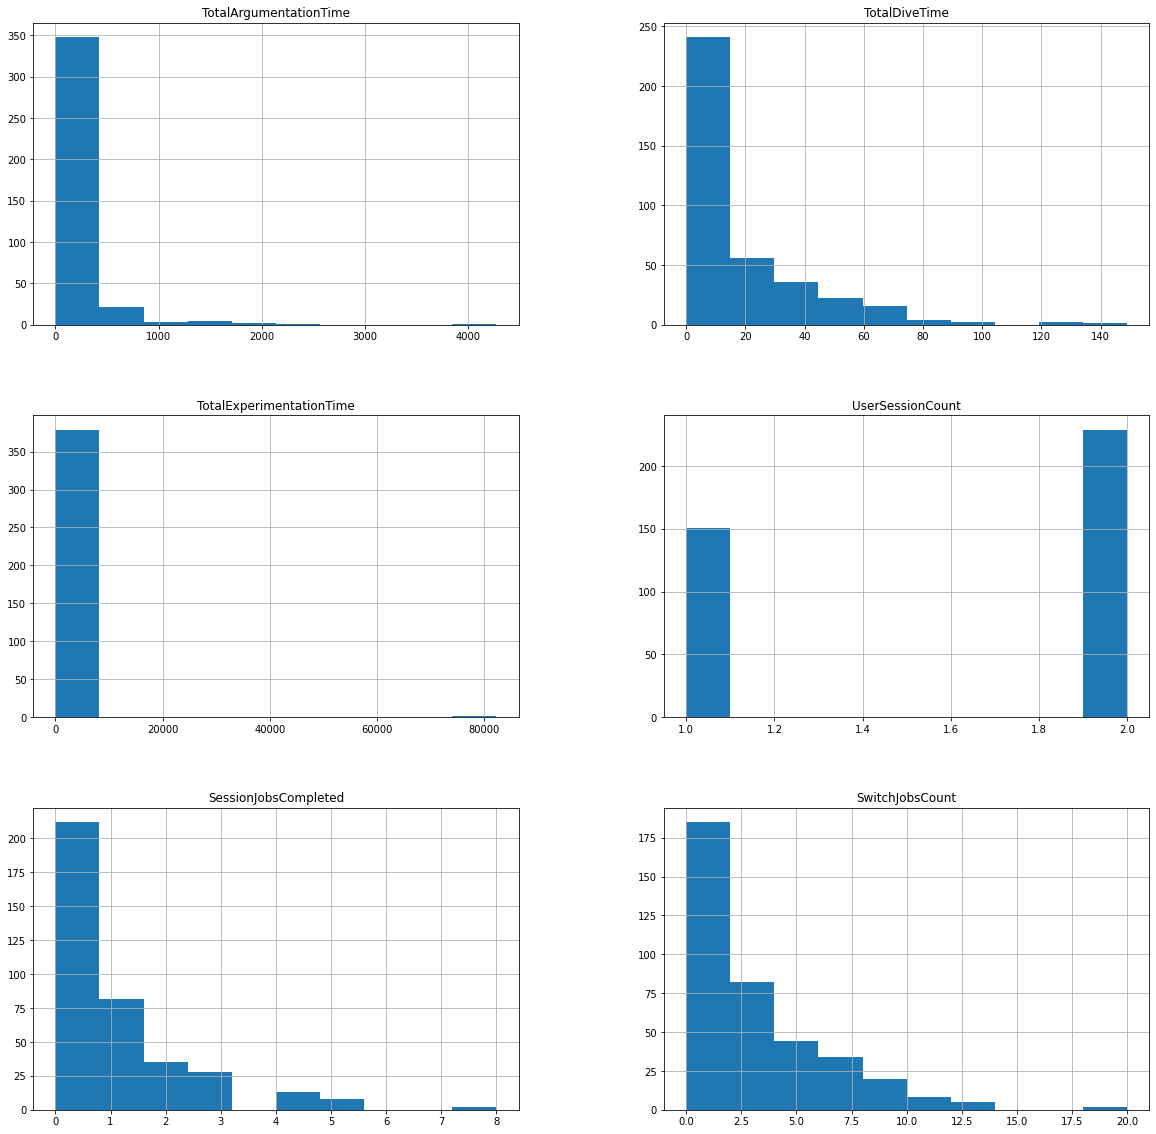

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
df_Aggregate[target_columns].hist(ax=ax)

Here we find that there may be an outlier in TotalExperimentationTime feature. Let's remove it and impute with 0. For some other data, you can do your own cleaning and use other imputation method.

In [ ]:
df_session.loc[df_session.TotalExperimentationTime.dt.total_seconds() > 5000]

,index,SessionID,PlayerID,ActiveTime,JobsCompleted,SessionDiveSitesCount,SessionDuration,SessionGuideCount,SessionHelpCount,SessionID.1,SessionJobsCompleted,SwitchJobsCount,TopJobCompletionDestinations,TopJobSwitchDestinations,TotalArgumentationTime,TotalDiveTime,TotalExperimentationTime,job0_JobArgumentationTime,job1_JobArgumentationTime,job2_JobArgumentationTime,job3_JobArgumentationTime,job4_JobArgumentationTime,job5_JobArgumentationTime,job6_JobArgumentationTime,job7_JobArgumentationTime,job8_JobArgumentationTime,job9_JobArgumentationTime,job10_JobArgumentationTime,job11_JobArgumentationTime,job12_JobArgumentationTime,job13_JobArgumentationTime,job14_JobArgumentationTime,job15_JobArgumentationTime,job16_JobArgumentationTime,job17_JobArgumentationTime,job18_JobArgumentationTime,job19_JobArgumentationTime,job20_JobArgumentationTime,job21_JobArgumentationTime,job22_JobArgumentationTime,job23_JobArgumentationTime,job24_JobArgumentationTime,job25_JobArgumentationTime,job26_JobArgumentationTime,job27_JobArgumentationTime,job28_JobArgumentationTime,job29_JobArgumentationTime,job30_JobArgumentationTime,job31_JobArgumentationTime,job32_JobArgumentationTime,job33_JobArgumentationTime,job34_JobArgumentationTime,job35_JobArgumentationTime,job36_JobArgumentationTime,job37_JobArgumentationTime,job38_JobArgumentationTime,job39_JobArgumentationTime,job40_JobArgumentationTime,job41_JobArgumentationTime,job42_JobArgumentationTime,job43_JobArgumentationTime,job44_JobArgumentationTime,job45_JobArgumentationTime,job46_JobArgumentationTime,job47_JobArgumentationTime,job48_JobArgumentationTime,job49_JobArgumentationTime,job50_JobArgumentationTime,job51_JobArgumentationTime,job52_JobArgumentationTime,job53_JobArgumentationTime,job54_JobArgumentationTime,job55_JobArgumentationTime,job56_JobArgumentationTime,job57_JobArgumentationTime,job58_JobArgumentationTime,job59_JobArgumentationTime,job0_JobCompletionTime,job1_JobCompletionTime,job2_JobCompletionTime,job3_JobCompletionTime,job4_JobCompletionTime,job5_JobCompletionTime,job6_JobCompletionTime,job7_JobCompletionTime,job8_JobCompletionTime,job9_JobCompletionTime,job10_JobCompletionTime,job11_JobCompletionTime,job12_JobCompletionTime,job13_JobCompletionTime,job14_JobCompletionTime,job15_JobCompletionTime,job16_JobCompletionTime,job17_JobCompletionTime,job18_JobCompletionTime,job19_JobCompletionTime,job20_JobCompletionTime,job21_JobCompletionTime,job22_JobCompletionTime,job23_JobCompletionTime,job24_JobCompletionTime,job25_JobCompletionTime,job26_JobCompletionTime,job27_JobCompletionTime,job28_JobCompletionTime,job29_JobCompletionTime,job30_JobCompletionTime,job31_JobCompletionTime,job32_JobCompletionTime,job33_JobCompletionTime,job34_JobCompletionTime,job35_JobCompletionTime,job36_JobCompletionTime,job37_JobCompletionTime,job38_JobCompletionTime,job39_JobCompletionTime,job40_JobCompletionTime,job41_JobCompletionTime,job42_JobCompletionTime,job43_JobCompletionTime,job44_JobCompletionTime,job45_JobCompletionTime,job46_JobCompletionTime,job47_JobCompletionTime,job48_JobCompletionTime,job49_JobCompletionTime,job50_JobCompletionTime,job51_JobCompletionTime,job52_JobCompletionTime,job53_JobCompletionTime,job54_JobCompletionTime,job55_JobCompletionTime,job56_JobCompletionTime,job57_JobCompletionTime,job58_JobCompletionTime,job59_JobCompletionTime,job0_JobDiveSitesCount,job1_JobDiveSitesCount,job2_JobDiveSitesCount,job3_JobDiveSitesCount,job4_JobDiveSitesCount,job5_JobDiveSitesCount,job6_JobDiveSitesCount,job7_JobDiveSitesCount,job8_JobDiveSitesCount,job9_JobDiveSitesCount,job10_JobDiveSitesCount,job11_JobDiveSitesCount,job12_JobDiveSitesCount,job13_JobDiveSitesCount,job14_JobDiveSitesCount,job15_JobDiveSitesCount,job16_JobDiveSitesCount,job17_JobDiveSitesCount,job18_JobDiveSitesCount,job19_JobDiveSitesCount,job20_JobDiveSitesCount,job21_JobDiveSitesCount,job22_JobDiveSitesCount,job23_JobDiveSitesCount,job24_JobDiveSitesCount,job25_JobDiveSitesCount,job26_JobDiveSitesCount,job27_JobDiveSitesCount,job28_Job

In [ ]:
Experimentation_columns = df_session.columns[df_session.columns.str.contains("JobExperimentation")]
temp = df_session.loc[df_session.TotalExperimentationTime.dt.total_seconds() > 5000, Experimentation_columns]
temp

,job0_JobExperimentationTime,job1_JobExperimentationTime,job2_JobExperimentationTime,job3_JobExperimentationTime,job4_JobExperimentationTime,job5_JobExperimentationTime,job6_JobExperimentationTime,job7_JobExperimentationTime,job8_JobExperimentationTime,job9_JobExperimentationTime,job10_JobExperimentationTime,job11_JobExperimentationTime,job12_JobExperimentationTime,job13_JobExperimentationTime,job14_JobExperimentationTime,job15_JobExperimentationTime,job16_JobExperimentationTime,job17_JobExperimentationTime,job18_JobExperimentationTime,job19_JobExperimentationTime,job20_JobExperimentationTime,job21_JobExperimentationTime,job22_JobExperimentationTime,job23_JobExperimentationTime,job24_JobExperimentationTime,job25_JobExperimentationTime,job26_JobExperimentationTime,job27_JobExperimentationTime,job28_JobExperimentationTime,job29_JobExperimentationTime,job30_JobExperimentationTime,job31_JobExperimentationTime,job32_JobExperimentationTime,job33_JobExperimentationTime,job34_JobExperimentationTime,job35_JobExperimentationTime,job36_JobExperimentationTime,job37_JobExperimentationTime,job38_JobExperimentationTime,job39_JobExperimentationTime,job40_JobExperimentationTime,job41_JobExperimentationTime,job42_JobExperimentationTime,job43_JobExperimentationTime,job44_JobExperimentationTime,job45_JobExperimentationTime,job46_JobExperimentationTime,job47_JobExperimentationTime,job48_JobExperimentationTime,job49_JobExperimentationTime,job50_JobExperimentationTime,job51_JobExperimentationTime,job52_JobExperimentationTime,job53_JobExperimentationTime,job54_JobExperimentationTime,job55_JobExperimentationTime,job56_JobExperimentationTime,job57_JobExperimentationTime,job58_JobExperimentationTime,job59_JobExperimentationTime
169,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days 00:01:15,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days,0 days


Notice: I used a hacky approach to remove outliers here

In [ ]:
df_Aggregate.TotalExperimentationTime = df_Aggregate.TotalExperimentationTime.mask(df_Aggregate.TotalExperimentationTime>5000, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50bc87a710>,
      dtype=object)

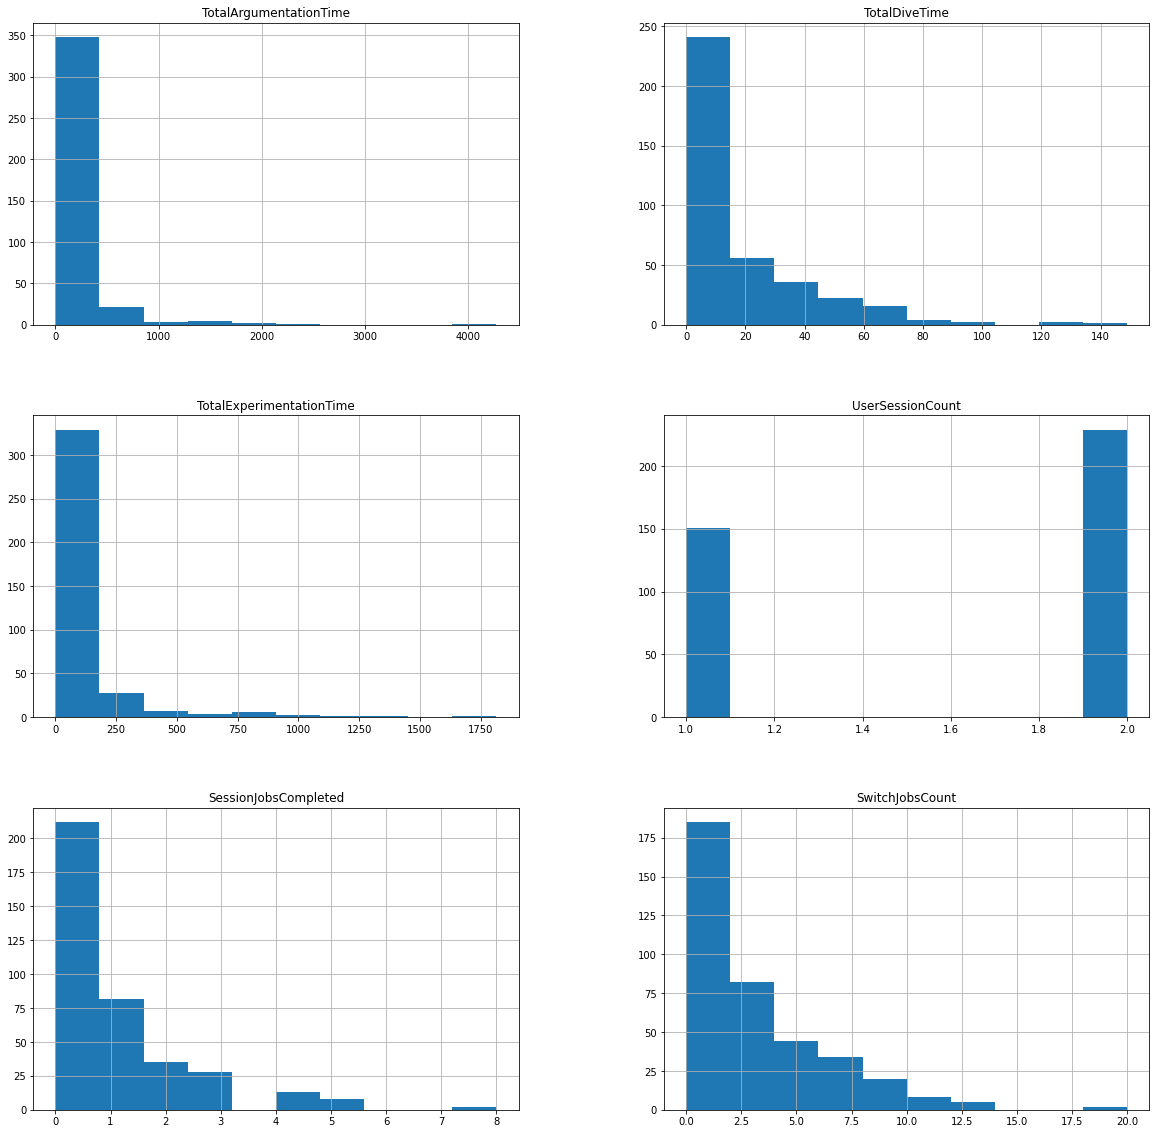

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
df_Aggregate[target_columns].hist(ax=ax)

In [ ]:
col1 = 'SessionJobsCompleted' #@param{type:"string"}
col2 = 'SwitchJobsCount'#@param{type:"string"}

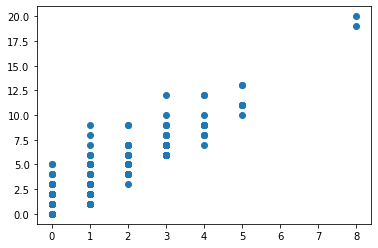

In [ ]:
plt.scatter(df_Aggregate[col1], df_Aggregate[col2])

In [ ]:
col1 = 'SessionHelpCount' #@param{type:"string"}
col2 = 'SessionJobsCompleted'#@param{type:"string"}

Text(0, 0.5, 'SessionJobsCompleted')

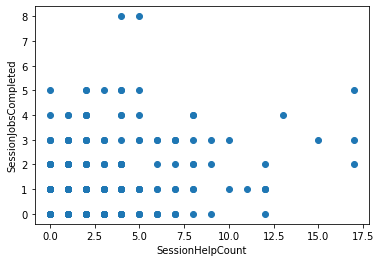

In [ ]:
plt.scatter(df_Aggregate[col1], df_Aggregate[col2])
plt.xlabel(col1)
plt.ylabel(col2)

You may want to see more advanced relationship via plots. Here is an example

Text(0, 0.5, 'SessionJobsCompleted/ActiveTime')

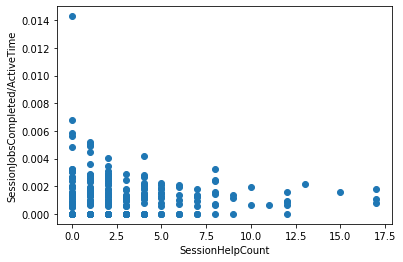

In [ ]:
plt.scatter(df_Aggregate.SessionHelpCount, df_Aggregate.SessionJobsCompleted/df_Aggregate.ActiveTime)
plt.xlabel("SessionHelpCount")
plt.ylabel("SessionJobsCompleted/ActiveTime")

next question: what do we want for the tests/visualizations/research?
do we need to step further into our feature systems

# Pairwise test

In [ ]:
#@markdown Choose your own metric for test here
Group_column = "TotalDiveTime" #@param {type:'string'}
Dividing_value = "20" #@param {type: 'string'}
Interested_column = "TotalExperimentationTime" #@param {type: 'string'}

In [ ]:
df_Aggregate['groups'] = df_Aggregate[Group_column].ge(20)

In [ ]:
df_Aggregate.shape

(380, 21)

In [ ]:
pairwise = pairwise_tukeyhsd(endog=df_Aggregate[Interested_column], groups=df_Aggregate.groups, alpha=0.05)
print(pairwise)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 False   True   36.683 0.1157 -9.0625 82.4285  False
----------------------------------------------------
